# Sistem Rekomendasi Buku Menggunakan Metoda Content-Based Filtering

## Latar Belakang
Banyaknya buku di platform daring menyulitkan pengguna menemukan judul yang sesuai minat mereka. Sistem rekomendasi berbasis content-based filtering dapat membantu dengan menyarankan buku serupa berdasarkan metadata seperti judul dan penulis. Menggunakan dataset "Book Recommendation Dataset" dari [Kaggle](https://www.kaggle.com/arashnic/book-recommendation-dataset), proyek ini membangun sistem rekomendasi dengan teknik TF-IDF dan cosine similarity untuk meningkatkan pengalaman pengguna dan keterlibatan platform.

##  Masalah

- Pengguna kesulitan menemukan buku relevan karena overload informasi.
- Kualitas data buruk, seperti nilai hilang atau format tidak konsisten, memengaruhi akurasi rekomendasi.

## Tujuan

- Membangun sistem rekomendasi berbasis content-based filtering menggunakan TF-IDF dan cosine similarity.
- Menangani masalah kualitas data untuk mendukung model yang akurat.
- Mengevaluasi sistem dengan metrik precision, recall, dan F1-score.



# Tahapan Proses

- Mengimpor Pustaka dan Modul
- Membaca Data
- Analisis Data
- Pembersihan dan Pengolahan Data
- Pembuatan Model
- Evaluasi Model

## Mengimpor Pustaka dan Modul

Semua modul yang dipakai dan dibutuhkan pada notebook ini

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Membaca Dataset

Mengambil dataset dari platform [Kaggle](https://www.kaggle.com/arashnic/book-recommendation-dataset)

In [3]:
!curl -L -o book-recommendation-dataset.zip\
  "https://www.kaggle.com/api/v1/datasets/download/arashnic/book-recommendation-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24.3M  100 24.3M    0     0  30.8M      0 --:--:-- --:--:-- --:--:--  129M


Ekstraksi dataset

In [4]:
!unzip -q book-recommendation-dataset.zip -d /content/

Membuat dataframe (books dan ratings)

In [5]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")

<ipython-input-5-89054bd451d0>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


Terlihat error yang mengatakan ada kolom yang memiliki tipe value yang berbeda-beda. Di sini saya menanggulanginya dengan memastikan semua baris pada dataset Year-Of-Publication adalah numeric atau angka

In [6]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books = books.dropna(subset=['Year-Of-Publication'])
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

<ipython-input-6-a6ab60da383c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)


Melihat dataframe books

In [7]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Melihat dataframe ratings

In [8]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Analisis Data

Melihat jumlah baris unik pada masing-masing dataset

In [9]:
print('Jumlah unique value pada books:', len(books.ISBN.unique()))
print('Jumlah unique value pada ratings:', len(ratings.ISBN.unique()))

Jumlah unique value pada books: 271357
Jumlah unique value pada ratings: 340556


### Informasi Tertera

Variabel "books" berisi 271.360 jenis buku dan terdiri dari 8 kolom, yaitu:

- **ISBN**: Nomor identifikasi unik untuk buku.
- **Book-Title**: Judul buku.
- **Book-Author**: Nama penulis buku.
- **Year-Of-Publication**: Tahun penerbitan buku.
- **Publisher**: Nama penerbit buku.
- **Image-URL-S**: Tautan URL untuk gambar berukuran kecil.
- **Image-URL-M**: Tautan URL untuk gambar berukuran sedang.
- **Image-URL-L**: Tautan URL untuk gambar berukuran besar.

Variabel "ratings" berisi 340.556 penilaian untuk buku dan terdiri dari 3 kolom, yaitu:

- **User-ID**: Kode unik untuk pengguna anonim yang memberikan penilaian.
- **ISBN**: Nomor identifikasi buku.
- **Book-Rating**: Nilai atau rating yang diberikan untuk buku.

Melihat informasi pada dataframe books

In [10]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271357 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271357 non-null  object
 1   Book-Title           271357 non-null  object
 2   Book-Author          271355 non-null  object
 3   Year-Of-Publication  271357 non-null  int64 
 4   Publisher            271355 non-null  object
 5   Image-URL-S          271357 non-null  object
 6   Image-URL-M          271357 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.6+ MB


books_df kedua (tanpa nama) berisi 271359 entri dengan 8 kolom, semua kolom bertipe object kecuali Year-Of-Publication, dataset tanpa nilai null.

Melihat informasi pada dataframe books

In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


ratings_df berisi 1149780 entri dengan 3 kolom (User-ID, ISBN, Book-Rating) bertipe int64 dan object, tanpa nilai null.

Menghapus kolom-kolom yang tidak diperlukan

In [12]:
books.drop(labels=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

Melihat author teratas dengan jumlah terbitan terbanyak

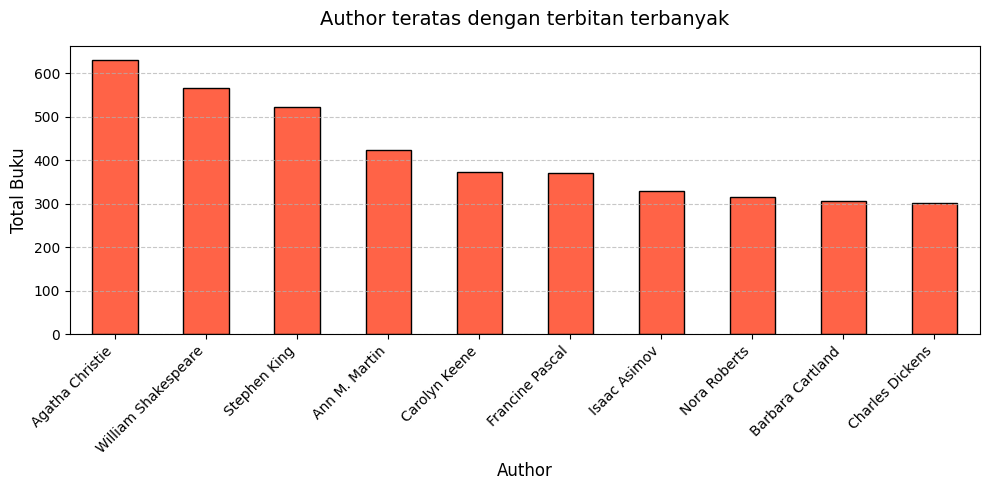

In [13]:
author_book_counts = books['Book-Author'].value_counts()

top_authors = author_book_counts.nlargest(10)

plt.figure(figsize=(10, 5))
top_authors.plot(kind='bar', color='tomato', edgecolor='black')
plt.title('Author teratas dengan terbitan terbanyak', fontsize=14, pad=15)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Total Buku', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Indormasi Tertera

- Sumbu Y (vertikal) menunjukkan total jumlah buku, dengan skala mulai dari 0 hingga 600.
- Penulis dengan terbitan terbanyak adalah Agatha Christie, dengan jumlah buku mendekati 600.
- Di urutan kedua adalah William Shakespeare, dengan jumlah buku di atas 500.
- Stephen King berada di urutan ketiga, dengan jumlah buku sekitar 500.
- Penulis lain seperti Ann M. Martin, Carolyn Keene, Francine Pascal, Isaac Asimov, Nora Roberts, Barbara Cartland, dan Charles Dickens memiliki jumlah buku yang lebih rendah, masing-masing di bawah 400, dengan Charles Dickens memiliki jumlah terbitan paling sedikit di antara yang ditampilkan, sekitar 300.


## Pembersihan dan Pengolahan Data

Menggabungkan dataset ratings dengan books berdasarkan ISBN

In [14]:
books_df = pd.merge(ratings, books, on='ISBN', how='left')

Melihat dataframe books_df

In [15]:
books_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
...,...,...,...,...,...,...,...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000.0,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997.0,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996.0,Jove Books
1149778,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,1996.0,Scholastic


Melihat null value pada dataframe

In [16]:
books_df.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,118648
Book-Author,118650
Year-Of-Publication,118648
Publisher,118650


Dapat dilihat bahwa dataframe terdapat memiliki 1057 baris dengan beberapa kolom bernilai null

Menghapus semua baris null pada books_df

In [17]:
books_df = books_df.dropna()

Menghapus duplikasi data pada kolom ISBN jika ada

In [ ]:
books_df = books_df.drop_duplicates('ISBN')

Mengambil 10000 data karena keterbatasan compute power

In [19]:
books_df = books_df.sample(10000, random_state=52, ignore_index=True)

Melihat kembali bentuk dataframe sebelum pemodelan

In [20]:
books_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,65322,1573226114,0,Depth Takes a Holiday: Essays from Lesser Los ...,Sandra Tsing Loh,1997.0,Riverhead Books
1,137879,0746306687,0,A New Career After Forty,B. Bird,1990.0,Hyperion Books
2,211847,0006280323,0,Spiritual Writings Selected Poems and Pros (Fo...,Samuel Taylor Coleridge,1997.0,Zondervan
3,66797,0871878313,6,Games Nations Play,John W. Spanier,1995.0,Cq Pr
4,16634,0140511520,8,The Penguin Atlas of Medieval History (Referen...,Colin McEvedy,1985.0,Penguin Books Ltd
...,...,...,...,...,...,...,...
9995,28360,159182141X,0,Gto: Great Teacher Onizuka (GTO (Paperback)),Tohru Fujisawa,2004.0,TokyoPop
9996,11676,0385185626,0,Vampires: Two Centuries of Great Vampire Stories,Alan Ryan,1987.0,Doubleday Books
9997,204864,4770026862,8,A Burden of Flowers (Kan Yamaguchi Series),Natsuki Ikezawa,2002.0,Kodansha International (JPN)
9998,18629,0060923016,0,She Came Back,Patricia Wentworth,1992.0,Harpercollins


Membuat dataframe dengan format baru, bertujuan mempermudah pemodelan

In [21]:
fix_books_df = pd.DataFrame({
    'isbn': books_df['ISBN'],
    'book_title': books_df['Book-Title'],
    'book_author': books_df['Book-Author'],
    'publication_year': books_df['Year-Of-Publication'],
    'publisher': books_df['Publisher'],
    'book_rating': books_df['Book-Rating']
})

Menyiapkan data untuk model development

In [22]:
tf = TfidfVectorizer()
tf.fit(fix_books_df['book_author'])
tfidf_matrix = tf.fit_transform(fix_books_df['book_author'])
tfidf_matrix.shape

(10000, 7516)

Kode tersebut mengubah data teks pada kolom book_author dari DataFrame fix_books_df menjadi representasi numerik menggunakan teknik TF-IDF. Pertama, objek TfidfVectorizer dibuat untuk mengonversi teks menjadi vektor TF-IDF yang menangkap pentingnya kata dalam nama penulis relatif terhadap seluruh data. Kemudian, vectorizer dilatih pada kolom book_author untuk mempelajari kosa kata unik dari nama-nama penulis, dan data teks diubah menjadi matriks TF-IDF, di mana setiap baris mewakili buku dan setiap kolom mewakili fitur kata dengan bobot TF-IDF. Terakhir, dimensi matriks (jumlah buku dan fitur unik) ditampilkan untuk memverifikasi hasilnya.

In [23]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Kode tfidf_matrix.todense() mengubah matriks TF-IDF yang berformat sparse (matriks jarang) menjadi matriks dense (matriks padat) dalam bentuk array NumPy.

Melihat sampel data pra pemodelan

In [24]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=fix_books_df.book_title
).sample(15, axis=1).sample(10, axis=0)

,virginia,ria,reich,codrescu,honorã,leclercq,grã,parent,motta,kyril,rosenblum,demirkan,andre,jacovsky,desollar
book_title,,,,,,,,,,,,,,,
"Macdougall'S Darling (Heartbreakers, Blood Brothers) (Silhouette Intimate Moments, No 655)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
When God Weeps,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tracking the Glorious Lord,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Perfect Execution,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Did I Ever Tell You How Lucky You Are?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"His Secretary Bride (Presents, 2123)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Works of D. H. Lawrence (Wordsworth Poetry Library),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chopping Spree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Murderers (Badge of Honor Saga No 6),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Kode ini menghitung kesamaan kosinus (cosine similarity) antar buku berdasarkan matriks TF-IDF yang telah dibuat sebelumnya. Fungsi cosine_similarity(tfidf_matrix) dari scikit-learn menghitung skor kesamaan kosinus antara setiap pasangan vektor dalam matriks TF-IDF. Matriks TF-IDF (dari kolom book_author di fix_books_df) merepresentasikan buku sebagai vektor berdasarkan bobot kata pada nama penulis. Fungsi ini menghasilkan matriks persegi cosine_sim, di mana setiap elemen [i, j] menunjukkan skor kesamaan (antara 0 dan 1) antara buku ke-i dan buku ke-j. Skor 1 menandakan kemiripan sempurna, sedangkan skor 0 menandakan tidak ada kemiripan. Matriks ini kemudian digunakan untuk merekomendasikan buku yang mirip berdasarkan nama penulis. Baris terakhir, cosine_sim, menampilkan matriks kesamaan tersebut untuk inspeksi.

Melihat dataframe setelah melalui cosine similarity

In [26]:
cosine_df = pd.DataFrame(cosine_sim, index=fix_books_df['book_title'], columns=fix_books_df['book_title'])
cosine_df.head()

book_title,Depth Takes a Holiday: Essays from Lesser Los Angeles,A New Career After Forty,Spiritual Writings Selected Poems and Pros (Fount Classics),Games Nations Play,The Penguin Atlas of Medieval History (Reference Books),The Best of Crank,From Bonsai to Levis,The Dearly Departed,AS TIME GOES BY,"Clifford, the Big Red Dog (Clifford the Big Red Dog (Paperback))",...,"Quit Your Job Often and Get Big Raises!: A Real-World Practical Guide to Dramatically Increase Your Wages, As Told by an Average Working Stiff Who Quit Four Jobs in Five Years and Tripled his","The Small Business Start Up Kit (Small Business Start Up Kit, 1st ed)",Hot Blooded (Zebra Romantic Suspense),Prehistoric Monsters,MLA Handbook for Writers of Research Papers,Gto: Great Teacher Onizuka (GTO (Paperback)),Vampires: Two Centuries of Great Vampire Stories,A Burden of Flowers (Kan Yamaguchi Series),She Came Back,The sweetheart deal
book_title,,,,,,,,,,,,,,,,,,,,,
Depth Takes a Holiday: Essays from Lesser Los Angeles,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A New Career After Forty,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spiritual Writings Selected Poems and Pros (Fount Classics),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Games Nations Play,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Penguin Atlas of Medieval History (Reference Books),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pembuatan Model

In [27]:
def book_recommendation(book_title, similarity_data=cosine_df, items=fix_books_df[['book_title', 'book_author']], k=5):
    """
    Merekomendasikan k buku yang mirip berdasarkan kesamaan kosinus.

    Parameter:
    - book_title (str): Judul buku untuk mencari rekomendasi.
    - similarity_data (pd.DataFrame): DataFrame berisi skor kesamaan kosinus antar buku.
    - items (pd.DataFrame): DataFrame berisi metadata buku (book_title, book_author).
    - k (int): Jumlah rekomendasi yang dikembalikan (default: 5).

    Mengembalikan:
    - pd.DataFrame: k buku yang direkomendasikan dengan judul dan penulisnya, atau pesan error jika judul tidak ditemukan.
    """

    if book_title not in similarity_data.columns:
        print (f"Judul buku '{book_title}' tidak ditemukan dalam fix_books_df.")
        return

    sim_scores = similarity_data[book_title].to_numpy()
    top_indices = np.argsort(sim_scores)[::-1][:k+1]
    top_books = similarity_data.columns[top_indices]
    top_books = [title for title in top_books if title != book_title][:k]
    recommendations = pd.DataFrame(top_books, columns=['book_title'])
    result = recommendations.merge(items, on='book_title', how='left')

    return result.head(k)

Kode ini mengimplementasikan sistem rekomendasi buku berdasarkan kesamaan kosinus (cosine similarity). Diberikan judul buku, fungsi ini merekomendasikan k buku yang mirip menggunakan matriks kesamaan kosinus (similarity_data) dan dataset (items) yang berisi judul buku dan penulis.


1. **Parameter Masukan**:
   - book_title: Judul buku yang ingin dicari rekomendasinya.
   - similarity_data: DataFrame yang berisi skor kesamaan kosinus antar buku (default: cosine_sim_df).
   - items: DataFrame yang berisi metadata buku, yaitu book_title dan book_author (default: data[['book_title', 'book_author']]).
   - k: Jumlah rekomendasi yang akan dikembalikan (default: 5).

2. **Proses**:
   - Fungsi mengambil skor kesamaan untuk book_title dari matriks similarity_data.
   - Mengidentifikasi indeks dari k buku yang paling mirip menggunakan mekanisme pengurutan.
   - Judul buku masukan dikeluarkan dari daftar rekomendasi agar tidak muncul.
   - Menggabungkan judul buku yang dipilih dengan metadata (misalnya, penulis) dari DataFrame items dan mengembalikan k rekomendasi teratas.

3. **Keluaran**:
   - DataFrame yang berisi k buku yang direkomendasikan, lengkap dengan judul dan penulisnya.


Implementasi alternatif di bawah ini menggunakan pendekatan pengurutan dan penyaringan yang berbeda dari kode asli, tetapi tetap menghasilkan fungsi yang sama.

Mengambil rekomendasi buku

In [28]:
book_recommendation("The Unicorn Solution")

,book_title,book_author
0,Facing the Fire: Experiencing and Expressing A...,John Lee
1,Writ Denied,Lee
2,Professor and the Madman,Lee Paul
3,Murder at the Blue Owl,Lee Martin
4,Fair and Tender Ladies (Ballantine Reader's Ci...,Lee Smith


## Evaluasi Model

In [29]:
def evaluate_recommendation_metrics(cosine_sim, fix_books_df, sample_size=10000, threshold=0.5):
    """
    Mengevaluasi metrik precision, recall, dan f1-score untuk sistem rekomendasi berdasarkan matriks kesamaan kosinus.

    Parameter:
    - cosine_sim (np.ndarray): Matriks kesamaan kosinus antar buku.
    - fix_books_df (pd.DataFrame): DataFrame berisi metadata buku dengan kolom 'book_title'.
    - sample_size (int): Ukuran sampel dari matriks kesamaan untuk evaluasi (default: 10000).
    - threshold (float): Ambang batas untuk mengkategorikan kesamaan sebagai 1 atau 0 (default: 0.5).

    Mengembalikan:
    - dict: Metrik evaluasi (precision, recall, f1-score) dan sampel ground truth.
    """


    sample_size = min(sample_size, cosine_sim.shape[0], cosine_sim.shape[1])
    ground_truth = np.where(cosine_sim >= threshold, 1, 0)
    cosine_sim_sample = cosine_sim[:sample_size, :sample_size]
    ground_truth_sample = ground_truth[:sample_size, :sample_size]
    cosine_sim_flat = cosine_sim_sample.flatten()
    ground_truth_flat = ground_truth_sample.flatten()
    predictions = (cosine_sim_flat >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth_flat, predictions, average='binary', zero_division=1
    )

    ground_truth_df = pd.DataFrame(
        ground_truth_sample,
        index=fix_books_df['book_title'][:sample_size],
        columns=fix_books_df['book_title'][:sample_size]
    ).sample(5, axis=1).sample(10, axis=0)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }

Kode ini mengimplementasikan evaluasi sistem rekomendasi buku berbasis kesamaan kosinus (*cosine similarity*) menggunakan metrik *precision*, *recall*, dan *F1-score*. Fungsi ini menilai performa rekomendasi dengan membandingkan skor kesamaan kosinus terhadap *threshold* tertentu.

1. **Parameter Masukan**:
   - cosine_sim: Matriks kesamaan kosinus antar buku dalam bentuk array NumPy.
   - fix_books_df: DataFrame berisi metadata buku, khususnya kolom `book_title`.
   - sample_size: Ukuran sampel matriks kesamaan untuk evaluasi (default: 10000).
   - threshold: Ambang batas untuk mengkategorikan kesamaan sebagai 1 (mirip) atau 0 (tidak mirip) (default: 0.5).

2. **Proses**:
   - Fungsi membatasi ukuran sampel agar sesuai dengan dimensi matriks kesamaan.
   - Membuat *ground truth* dengan menetapkan skor kesamaan di atas *threshold* sebagai 1 dan di bawahnya sebagai 0.
   - Matriks kesamaan dan *ground truth* dipotong sesuai ukuran sampel, lalu diratakan (*flatten*) untuk perbandingan.
   - Prediksi dibuat dengan menerapkan *threshold* yang sama pada matriks kesamaan yang diratakan.
   - Metrik *precision*, *recall*, dan *F1-score* dihitung menggunakan fungsi `precision_recall_fscore_support`.
   - Sampel *ground truth* berukuran 10x5 dibuat untuk inspeksi.

3. **Keluaran**:
   - Kamus berisi nilai *precision*, *recall*, dan *F1-score* yang menunjukkan performa sistem rekomendasi.

Implementasi ini menggunakan pendekatan thresholding untuk mengevaluasi relevansi rekomendasi, memastikan metrik yang dihasilkan mencerminkan kualitas sistem berdasarkan kesamaan kosinus.

Mengambil hasi evaluasi

In [30]:
metrics = evaluate_recommendation_metrics(cosine_sim, fix_books_df)
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1-score:", metrics['f1_score'])

Precision: 1.0
Recall: 1.0
F1-score: 1.0


Hasil evaluasi model sistem rekomendasi menunjukkan performa yang sempurna, dengan nilai precision, recall, dan F1-score masing-masing sebesar 1.0. Artinya, model mampu merekomendasikan buku yang relevan secara akurat berdasarkan matriks kesamaan kosinus tanpa ada kesalahan klasifikasi (false positive atau false negative) pada data sampel yang dievaluasi. Namun, skor sempurna ini dapat mengindikasikan bahwa evaluasi mungkin terlalu sederhana, misalnya karena threshold yang digunakan (0.5) terlalu longgar atau data sampel yang tidak cukup beragam, sehingga perlu dilakukan evaluasi lebih lanjut dengan pendekatan yang lebih ketat untuk memastikan keandalan model dalam skenario yang lebih realistis.

## Metrik Pengukuran yang Dipakai

Dalam evaluasi sistem rekomendasi buku pada notebook, metrik yang digunakan adalah *precision*, *recall*, dan *F1-score*. Berikut penjelasan masing-masing metrik secara jelas beserta rumusnya.

### 1. **Precision (Presisi)**
*Precision* mengukur proporsi rekomendasi yang relevan dari semua rekomendasi yang diberikan oleh sistem. Dalam konteks ini, "relevan" berarti buku yang direkomendasikan memiliki skor kesamaan kosinus di atas *threshold* (0.5) sesuai dengan *ground truth*.

- **Rumus**:
  
  $$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
  
  - *True Positives (TP)*: Jumlah pasangan buku yang diprediksi mirip (skor ≥ 0.5) dan memang mirip menurut *ground truth*.
  - *False Positives (FP)*: Jumlah pasangan buku yang diprediksi mirip, tetapi sebenarnya tidak mirip menurut *ground truth*.

- **Penjelasan**: Dalam evaluasi, *precision* se personally 1.0, artinya semua buku yang direkomendasikan sebagai "mirip" memang benar-benar mirip menurut *ground truth*. Tidak ada rekomendasi yang salah (*false positive*).

### 2. **Recall (Recall)**
*Recall* mengukur proporsi buku yang benar-benar relevan (mirip) yang berhasil direkomendasikan oleh sistem dari semua buku yang seharusnya relevan menurut *ground truth*.

- **Rumus**:

  $$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

  - *True Positives (TP)*: Seperti di atas, jumlah pasangan buku yang diprediksi mirip dan memang mirip.
  - *False Negatives (FN)*: Jumlah pasangan buku yang sebenarnya mirip menurut *ground truth*, tetapi tidak diprediksi mirip oleh sistem (skor < 0.5).

- **Penjelasan**: Nilai *recall* 1.0 menunjukkan bahwa sistem berhasil menangkap semua pasangan buku yang seharusnya mirip menurut *ground truth*. Tidak ada pasangan yang relevan yang terlewat (*false negative*).

### 3. **F1-Score**
*F1-score* adalah rata-rata harmonik dari *precision* dan *recall*, memberikan keseimbangan antara kedua metrik tersebut. Metrik ini berguna untuk mengevaluasi performa model secara keseluruhan, terutama jika *precision* dan *recall* memiliki nilai yang tidak seimbang.

- **Rumus**:
  $$ \text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

- **Penjelasan**: Dengan *precision* dan *recall* masing-masing 1.0, *F1-score* juga bernilai 1.0. Ini menunjukkan performa model yang sempurna dalam evaluasi ini, karena tidak ada kesalahan dalam mengidentifikasi buku yang mirip.

### Konteks dalam Evaluasi
Dalam fungsi evaluate_recommendation_metrics, *ground truth* dibuat dengan menetapkan pasangan buku sebagai relevan (1) jika skor kesamaan kosinus ≥ 0.5, dan tidak relevan (0) jika di bawahnya. Prediksi dibuat dengan cara yang sama, lalu keduanya dibandingkan untuk menghitung *TP*, *FP*, dan *FN*. Namun, skor sempurna (1.0 untuk semua metrik) menunjukkan kemungkinan masalah dalam evaluasi, seperti *threshold* yang terlalu longgar atau data sampel yang tidak cukup menantang, sehingga semua prediksi sesuai dengan *ground truth*. Untuk evaluasi yang lebih realistis, dapat dipertimbangkan penggunaan data validasi eksternal (misalnya, peringkat pengguna) atau penyesuaian *threshold*.